# Predicting profile EV replacement - Binary Classification
Only EV models under 250,000 PLN and real score over threshold (5.2) middle point of edges between 1st and 99th percentile (outside values of two bells of real_scores) are recommended. Total 936 profiles:

Firstly importing the libraries:

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline, make_pipeline

Now we have to read the right file:

In [2]:
profiles = pd.read_csv('DATA/driving_profiles_cleared_BINARY_26_1.csv')
profiles.head()

,monitoring_start_month,monitoring_days,active_days,data_quality_score,reliability_score,car_use_score,driver_behavior_score,n_trips,fuel_costs,n_recommended_evs,...,median_trip_distance,average_pause_time,max_pause_time,median_pause_time,percentage_start_home,percentage_start_office,average_trip_duration_sec,percentage_charger_nearby,percentage_charger_fast_nearby,percentage_charger_3F_nearby
0,7,31,30,9.373888,4.692516,7.451583,6.467989,392,16625,0,...,3.732314,5591.336735,133880,557.5,7.397959,4.591837,1098.109694,13.520408,5.867347,7.653061
1,6,30,27,9.062229,6.138472,7.616548,5.732751,314,17664,0,...,3.879948,6739.085987,147051,703.0,8.280255,0.318471,1308.401274,13.057325,6.687898,6.369427
2,5,31,26,8.950726,5.415178,7.771661,6.493076,249,11769,0,...,4.442763,9403.775100,224802,606.0,9.638554,0.000000,1075.341365,13.654618,5.622490,8.032129
3,3,92,78,9.003805,5.945673,7.027738,5.758369,789,17323,0,...,4.491949,8688.593156,244481,606.0,9.632446,0.000000,1317.195184,14.575412,7.984791,6.590621
4,4,30,25,8.851813,5.518089,6.905178,5.513861,266,19741,0,...,3.343137,8229.680451,238754,552.0,9.022556,0.000000,1374.330827,14.661654,8.646617,6.015038


A new column `ev_replace` is created that contains:
* the value `0` if the profile should not be replaced with any EV
* the value `1` if the profile should be replaced with an EV

In [3]:
profiles['ev_replace'] = profiles['n_recommended_evs'].copy()
profiles.loc[profiles['n_recommended_evs'] > 0, 'ev_replace'] = 1

In [4]:
profiles.ev_replace.value_counts()

0    580
1    354
Name: ev_replace, dtype: int64

Now we drop columns that will not contribute to the machine learning process:

In [5]:
profiles = profiles.drop(columns=['n_recommended_evs'])

Next up, we have to create dummie variables for all the columns that have non continious numeric values:

In [6]:
profiles = pd.get_dummies(profiles, columns=['driver_name','body_type','monitoring_start_month'])

Here we can see the new shape of the data, 214 rows and 327 columns:

In [7]:
profiles.shape

(934, 158)

Fixing column names for lightGBM:

In [8]:
import re
profiles = profiles.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #fix error lgb does not support json characters

### ML Preprocessing

Now we shuffle the data and separate the column we want to predict afterwards:

In [9]:
profiles = profiles.sample(frac = 1, random_state=9) #shuffling data
target = profiles['ev_replace'].copy() # target column separated
profiles = profiles.drop(['ev_replace'], axis=1) #deleting target column from data

Next up we define the folds to be used for cross-validation after in order to ensure repeatability. We will use `leave one out` meaning each time the model is trained on N-1 observations and test it on the Nth:

In [38]:
loo = KFold(profiles.shape[0], shuffle=True, random_state=123)
fold_10 = KFold(10, shuffle=True, random_state=123)
fold_20 = KFold(20, shuffle=True, random_state=123)
fold_100 = KFold(100, shuffle=True, random_state=123)
fold_250 = KFold(250, shuffle=True, random_state=123)

Now we define a function to print the mean and standard deviation for a list of scores:

In [11]:
def print_scores(scores):
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

#### Dummy classifier
In order to compare our results, we will use a dummy classifier that always predicts $1$ for every case. Metric of accuracy firstly:

In [12]:
dummy_classifier = DummyClassifier(strategy='most_frequent')

scores = cross_val_score(dummy_classifier, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs=-1)
print_scores(scores)

Mean: 0.6209850107066381
Standard Deviation: 0.4851418629476481


### Decision trees
Firstly we will try the decision trees. We will use `GridSearchCV` to find the best parameters while also using cross validation to evaluate the general accuracy of the model
* We define the parameters we want to check with grid-search:

In [13]:
parameters = {'criterion': ('gini','entropy'),
              'splitter': ('best', 'random'),
              'max_features':('sqrt',None,'log2'),
              'class_weight':(None,'balanced'),
              'max_depth':(None,20,50),
              'min_samples_leaf':(1,3),
              'ccp_alpha':(0,0.4, 0.8),
              'min_impurity_decrease':(0, 0.5, 1)
             }

Defining the decision tree classifier:

In [15]:
clf = tree.DecisionTreeClassifier(random_state=7)

Next up the grid search classifier is declared:

In [17]:
gs_clf = GridSearchCV(clf, parameters,n_jobs=7, cv=fold_10, scoring='accuracy', verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [18]:
gs_clf.fit(profiles, target)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 1975 tasks      | elapsed:    4.7s
[Parallel(n_jobs=7)]: Done 5975 tasks      | elapsed:   12.3s
[Parallel(n_jobs=7)]: Done 11575 tasks      | elapsed:   22.6s
[Parallel(n_jobs=7)]: Done 12960 out of 12960 | elapsed:   25.3s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=7), n_jobs=7,
             param_grid={'ccp_alpha': (0, 0.4, 0.8),
                         'class_weight': (None, 'balanced'),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (None, 20, 50),
                         'max_features': ('sqrt', None, 'log2'),
                         'min_impurity_decrease': (0, 0.5, 1),
                         'min_samples_leaf': (1, 3),
                         'splitter': ('best', 'random')},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [19]:
gs_clf.best_params_

{'ccp_alpha': 0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 3,
 'splitter': 'best'}

We save the best estimator in a new variable to use it for cross-validation after: 

In [20]:
best_tree = gs_clf.best_estimator_

K-fold cross validation is used to make sure that the split of data does not affect the result.

Now, we check the accuracy since this metric gives a quick overview of the correctness of the predictions:

In [21]:
scores = cross_val_score(best_tree, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs=-1)
print_scores(scores)

Mean: 0.854389721627409
Standard Deviation: 0.3527150765204793


### Random forest
Now we will try the same steps for random forest. Firstly, the parameters are set:

In [22]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (50,100, 125,150,175,200),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'class_weight':('balanced_subsample','balanced',None),
              'max_features':('auto','sqrt','log2'),
              'warm_start':(True,False),
              'class_weight':(None,'balanced')
             }

Defining the random forest:

In [23]:
forest = RandomForestClassifier(random_state=7)

Next up the grid search classifier is declared:

In [24]:
gs_forest = GridSearchCV(forest, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [25]:
gs_forest.fit(profiles, target)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   13.3s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   31.9s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:   54.6s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  2.3min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  3.1min
[Parallel(n_jobs=7)]: Done 3387 tasks      | elapsed:  4.1min
[Parallel(n_jobs=7)]: Done 4824 tasks      | elapsed:  5.3min
[Parallel(n_jobs=7)]: Done 5760 out of 5760 | elapsed:  6.1min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(random_state=7), n_jobs=7,
             param_grid={'bootstrap': (True, False),
                         'class_weight': (None, 'balanced'),
                         'criterion': ('gini', 'entropy'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': (50, 100, 125, 150, 175, 200),
                         'oob_score': (True, False),
                         'warm_start': (True, False)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [26]:
gs_forest.best_params_

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'gini',
 'max_features': 'auto',
 'n_estimators': 125,
 'oob_score': False,
 'warm_start': True}

We save the best estimator in a new variable to use it for cross-validation after: 

In [27]:
best_forest = gs_forest.best_estimator_

Now k-fold cross validation with leave one out and for accuracy:

In [28]:
scores = cross_val_score(best_forest, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.9089935760171306
Standard Deviation: 0.2876182448606479


### Extremely randomized trees
Now we will try extremely randomized trees.
* Setting parameters:

In [29]:
parameters = {'criterion': ('gini','entropy'),
              'n_estimators': (50,75,100,125, 150,175,200),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'max_features':('sqrt',None,'log2'),
              'warm_start':(True,False),
              'class_weight':(None,'balanced'),
              'max_depth':(None,10)
             }

Defining the extremely randomized trees:

In [30]:
extremely_rts = ExtraTreesClassifier(random_state=7)

Next up the grid search classifier is declared:

In [31]:
gs_random_trees = GridSearchCV(extremely_rts, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [32]:
gs_random_trees.fit(profiles, target)

Fitting 10 folds for each of 1344 candidates, totalling 13440 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    7.9s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   26.6s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:   54.9s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  3.5min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed:  4.4min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed:  5.3min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed:  6.4min
[Parallel(n_jobs=7)]: Done 7561 tasks      | elapsed:  7.8min
[Parallel(n_jobs=7)]: Done 10433 tasks      | elapsed:  9.4min
[Parallel(n_jobs=7)]: Done 13271 tasks      | elapsed: 11.2min
[Parallel(n_jobs=7)]: Done 13440 out of 13440 | elapsed: 11

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=ExtraTreesClassifier(random_state=7), n_jobs=7,
             param_grid={'bootstrap': (True, False),
                         'class_weight': (None, 'balanced'),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (None, 10),
                         'max_features': ('sqrt', None, 'log2'),
                         'n_estimators': (50, 75, 100, 125, 150, 175, 200),
                         'oob_score': (True, False),
                         'warm_start': (True, False)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [33]:
gs_random_trees.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'n_estimators': 75,
 'oob_score': False,
 'warm_start': True}

We save the best estimator in a new variable to use it for cross-validation after: 

In [34]:
best_random_trees = gs_random_trees.best_estimator_

Now, k-fold cross validation with accuracy:

In [35]:
scores = cross_val_score(best_random_trees, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.9207708779443254
Standard Deviation: 0.2700960352799751


### Bagging classifier
Now we will try bagging classifier
* Setting parameters:

In [37]:
parameters = {'warm_start': (True,False),
              'bootstrap':(True,False),
              'oob_score':(True,False),
              'bootstrap_features':(True,False),
              'n_estimators': (10,15,20,25,30,40,50,60,70,80),
              'max_samples':(1,2,4,6,None),
              'max_features':(1,2,4,6,None)
             }

Defining the bagging classifier:

In [38]:
bagging_clf = BaggingClassifier(random_state=7)

Next up the grid search classifier is declared:

In [39]:
gs_bagging_clf = GridSearchCV(bagging_clf, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [40]:
gs_bagging_clf.fit(profiles, target)

Fitting 10 folds for each of 4000 candidates, totalling 40000 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 764 tasks      | elapsed:    8.1s
[Parallel(n_jobs=7)]: Done 2818 tasks      | elapsed:   27.2s
[Parallel(n_jobs=7)]: Done 4715 tasks      | elapsed:   44.1s
[Parallel(n_jobs=7)]: Done 7291 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 12742 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done 17514 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done 25994 tasks      | elapsed:  3.2min
[Parallel(n_jobs=7)]: Done 35324 tasks      | elapsed:  3.9min
[Parallel(n_jobs=7)]: Done 40000 out of 40000 | elapsed:  4.2min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=BaggingClassifier(random_state=7), n_jobs=7,
             param_grid={'bootstrap': (True, False),
                         'bootstrap_features': (True, False),
                         'max_features': (1, 2, 4, 6, None),
                         'max_samples': (1, 2, 4, 6, None),
                         'n_estimators': (10, 15, 20, 25, 30, 40, 50, 60, 70,
                                          80),
                         'oob_score': (True, False),
                         'warm_start': (True, False)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [41]:
gs_bagging_clf.best_params_

{'bootstrap': True,
 'bootstrap_features': True,
 'max_features': 6,
 'max_samples': 6,
 'n_estimators': 60,
 'oob_score': True,
 'warm_start': False}

We save the best estimator in a new variable to use it for cross-validation after: 

In [42]:
best_bagging_clf = gs_bagging_clf.best_estimator_

Firstly, k-fold cross validation with accuracy:

In [43]:
scores = cross_val_score(best_bagging_clf, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.7226980728051392
Standard Deviation: 0.4476668050781484


### AdaBoost classifier
Now we will try boost classifier
* Parameters:

In [45]:
parameters = {'algorithm': ('SAMME','SAMME.R'),
              'n_estimators': (50, 75, 100,125,150,175,200,250),
              'learning_rate':(0.3, 0.5,0.7,1)
             }

Defining the boost classifier:

In [46]:
clf = AdaBoostClassifier(random_state=7)

Next up the grid search classifier is declared:

In [47]:
gs_boost_clf = GridSearchCV(clf, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [48]:
gs_boost_clf.fit(profiles, target)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    3.9s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   27.4s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 640 out of 640 | elapsed:  1.7min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=AdaBoostClassifier(random_state=7), n_jobs=7,
             param_grid={'algorithm': ('SAMME', 'SAMME.R'),
                         'learning_rate': (0.3, 0.5, 0.7, 1),
                         'n_estimators': (50, 75, 100, 125, 150, 175, 200,
                                          250)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [49]:
gs_boost_clf.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.7, 'n_estimators': 100}

We save the best estimator in a new variable to use it for cross-validation after: 

In [50]:
best_boost_clf = gs_boost_clf.best_estimator_

Firstly, k-fold cross validation with accuracy:

In [51]:
scores = cross_val_score(best_boost_clf, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.9036402569593148
Standard Deviation: 0.2950839591740262


### Naive Baynes classifier
Now Gaussian classifier
* Parameters:

In [52]:
parameters = {'var_smoothing': (1e-9, 1e-10, 1e-11, 1e-12, 1e-13),
              'priors': (None,[0.5, 0.5])
             }

Defining the model classifier:

In [53]:
gaussian = GaussianNB()

Next up the grid search classifier is declared:

In [54]:
gs_gaussian = GridSearchCV(gaussian, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [55]:
gs_gaussian.fit(profiles, target)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  87 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=GaussianNB(), n_jobs=7,
             param_grid={'priors': (None, [0.5, 0.5]),
                         'var_smoothing': (1e-09, 1e-10, 1e-11, 1e-12, 1e-13)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [56]:
gs_gaussian.best_params_

{'priors': None, 'var_smoothing': 1e-13}

We save the best estimator in a new variable to use it for cross-validation after: 

In [57]:
best_gaussian = gs_gaussian.best_estimator_

K-fold cross validation with accuracy:

In [58]:
scores = cross_val_score(best_gaussian, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.797644539614561
Standard Deviation: 0.40175580647656606


### Support vector machines
Now we will try SVC.
* Firstly, the parameters:

In [59]:
parameters = {'SVC__C': (1, 0.85, 1.15,1.3),
              'SVC__kernel': ('linear','poly','rbf', 'sigmoid', 'precomputed'),
              'SVC__degree':(2,3,4),
              'SVC__gamma':('auto','scale'),
              'SVC__coef0':(0,0.5),
              'SVC__shrinking':(True, False),
              'SVC__probability':(True,False),
              'SVC__decision_function_shape':('ovo', 'ovr'),
              'SVC__tol':(1e-3, 1e-4, 1e-2)
             }

Defining the SVC classifier. In fact we have to create a pipeline because the SVM needs all the column data to be standardized meaning to have a mean of 0 and standard deviation of 1:

In [60]:
clf = Pipeline(steps = [ ('scaler',StandardScaler()), ('SVC',SVC(random_state=7))])

Next up the grid search classifier is declared:

In [61]:
gs_clf = GridSearchCV(clf, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [62]:
gs_clf.fit(profiles, target)

Fitting 10 folds for each of 5760 candidates, totalling 57600 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.5s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    9.8s
[Parallel(n_jobs=7)]: Done 533 tasks      | elapsed:   18.3s
[Parallel(n_jobs=7)]: Done 1605 tasks      | elapsed:   53.5s
[Parallel(n_jobs=7)]: Done 2671 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 3868 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 5666 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done 7555 tasks      | elapsed:  3.9min
[Parallel(n_jobs=7)]: Done 9891 tasks      | elapsed:  5.0min
[Parallel(n_jobs=7)]: Done 12420 tasks      | elapsed:  6.2min
[Parallel(n_jobs=7)]: Done 15279 tasks      | elapsed:  7.6min
[Parallel(n_jobs=7)]: Done 18407 tasks      | elapsed:  9.2min
[Parallel(n_jobs=7)]: Done 21872 tasks      | elapsed: 10.9min
[Parallel(n_jobs=7)]: Done 25490 tasks      | elapsed: 12.6min
[Parallel(n_jobs=7)]: Done 29053 tasks      | elapsed: 

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC', SVC(random_state=7))]),
             n_jobs=7,
             param_grid={'SVC__C': (1, 0.85, 1.15, 1.3), 'SVC__coef0': (0, 0.5),
                         'SVC__decision_function_shape': ('ovo', 'ovr'),
                         'SVC__degree': (2, 3, 4),
                         'SVC__gamma': ('auto', 'scale'),
                         'SVC__kernel': ('linear', 'poly', 'rbf', 'sigmoid',
                                         'precomputed'),
                         'SVC__probability': (True, False),
                         'SVC__shrinking': (True, False),
                         'SVC__tol': (0.001, 0.0001, 0.01)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [63]:
gs_clf.best_params_

{'SVC__C': 1.3,
 'SVC__coef0': 0.5,
 'SVC__decision_function_shape': 'ovo',
 'SVC__degree': 2,
 'SVC__gamma': 'scale',
 'SVC__kernel': 'poly',
 'SVC__probability': True,
 'SVC__shrinking': True,
 'SVC__tol': 0.001}

We save the best estimator in a new variable to use it for cross-validation after: 

In [64]:
best_svc = gs_clf.best_estimator_

K-fold cross validation with accuracy:

In [65]:
scores = cross_val_score(best_svc, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.9089935760171306
Standard Deviation: 0.28761824486064785


### SGD 
Next up stochastic gradient descent. 
* Parameters:

In [66]:
parameters = {'SGD__loss': ('hinge','log','modified_huber','squared_hinge','perceptron'),
              'SGD__penalty': ('l1','l2','elasticnet'),
              'SGD__alpha': (0.001, 0.0005, 0.0001, 0.00001),
              'SGD__fit_intercept': (True, False),
              'SGD__validation_fraction':(0.1, 0.2),
              'SGD__early_stopping':(True, False),
              #'SGD__learning_rate':('constant','optimal','invscaling','adaptive'),
              'SGD__tol':(1e-2,1e-3,1e-4),
              'SGD__class_weight': (None,'balanced'),
              'SGD__average':(True,False)
             }

Defining the SGD classifier. In fact we have to create a pipeline because the SGD needs all the column data to be standardized meaning to have a mean of 0 and standard deviation of 1:

In [67]:
clf = Pipeline(steps = [ ('scaler',StandardScaler()), ('SGD',SGDClassifier(random_state=7))])

Next up the grid search classifier is declared:

In [68]:
gs_clf = GridSearchCV(clf, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [69]:
gs_clf.fit(profiles, target)

Fitting 10 folds for each of 5760 candidates, totalling 57600 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 1250 tasks      | elapsed:    5.9s
[Parallel(n_jobs=7)]: Done 2654 tasks      | elapsed:   20.8s
[Parallel(n_jobs=7)]: Done 3718 tasks      | elapsed:   36.0s
[Parallel(n_jobs=7)]: Done 5518 tasks      | elapsed:   45.3s
[Parallel(n_jobs=7)]: Done 7396 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 9660 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 12506 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 15906 tasks      | elapsed:  2.3min
[Parallel(n_jobs=7)]: Done 19461 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done 23661 tasks      | elapsed:  3.3min
[Parallel(n_jobs=7)]: Done 28443 tasks      | elapsed:  4.0min
[Parallel(n_jobs=7)]: Done 33443 tasks      | elapsed:  4.5min
[Parallel(n_jobs=7)]: Done 38843 tasks      | elapsed:  5.0min
[Parallel(n_jobs=7)]: Done 44643 tasks      | elaps

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SGD', SGDClassifier(random_state=7))]),
             n_jobs=7,
             param_grid={'SGD__alpha': (0.001, 0.0005, 0.0001, 1e-05),
                         'SGD__average': (True, False),
                         'SGD__class_weight': (None, 'balanced'),
                         'SGD__early_stopping': (True, False),
                         'SGD__fit_intercept': (True, False),
                         'SGD__loss': ('hinge', 'log', 'modified_huber',
                                       'squared_hinge', 'perceptron'),
                         'SGD__penalty': ('l1', 'l2', 'elasticnet'),
                         'SGD__tol': (0.01, 0.001, 0.0001),
                         'SGD__validation_fraction': (0.1, 0.2)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [70]:
gs_clf.best_params_

{'SGD__alpha': 0.0005,
 'SGD__average': True,
 'SGD__class_weight': 'balanced',
 'SGD__early_stopping': True,
 'SGD__fit_intercept': True,
 'SGD__loss': 'modified_huber',
 'SGD__penalty': 'elasticnet',
 'SGD__tol': 0.01,
 'SGD__validation_fraction': 0.1}

We save the best estimator in a new variable to use it for cross-validation after: 

In [71]:
best_sgd = gs_clf.best_estimator_

K-fold cross validation with accuracy:

In [72]:
scores = cross_val_score(best_sgd, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.8961456102783726
Standard Deviation: 0.30507155792891566


### KNeighborsClassifier
Now k nearest neighbors will be used.
* Parameters:

In [73]:
parameters = {'n_neighbors': range(1,70),
              'weights': ('uniform','distance'),
              'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
              'p':(1,2),
              #'metric': ('precomputed','minkowski'),
              'leaf_size':(5,10,20,30,40)
             }

Defining the model classifier:

In [74]:
neigh_clf = KNeighborsClassifier()

Next up the grid search classifier is declared:

In [75]:
gs_neigh = GridSearchCV(neigh_clf, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [76]:
gs_neigh.fit(profiles, target)

Fitting 10 folds for each of 5520 candidates, totalling 55200 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=7)]: Done 674 tasks      | elapsed:    5.8s
[Parallel(n_jobs=7)]: Done 1674 tasks      | elapsed:   14.5s
[Parallel(n_jobs=7)]: Done 3074 tasks      | elapsed:   26.6s
[Parallel(n_jobs=7)]: Done 4874 tasks      | elapsed:   43.3s
[Parallel(n_jobs=7)]: Done 7074 tasks      | elapsed:   59.9s
[Parallel(n_jobs=7)]: Done 9674 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 12674 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 16074 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 19874 tasks      | elapsed:  2.3min
[Parallel(n_jobs=7)]: Done 24074 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 28674 tasks      | elapsed:  3.1min
[Parallel(n_jobs=7)]: Done 33674 tasks      | elapsed:  3.7min
[Parallel(n_jobs=7)]: Done 39074 tasks      | elapsed:  4.3min
[Parallel(n_jobs=7)]: Done 54854 tasks      | elapse

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=7,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'leaf_size': (5, 10, 20, 30, 40),
                         'n_neighbors': range(1, 70), 'p': (1, 2),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [77]:
gs_neigh.best_params_

{'algorithm': 'auto',
 'leaf_size': 5,
 'n_neighbors': 56,
 'p': 1,
 'weights': 'distance'}

We save the best estimator in a new variable to use it for cross-validation after: 

In [78]:
best_neigh = gs_neigh.best_estimator_

K-fold cross validation with accuracy:

In [79]:
scores = cross_val_score(best_neigh, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.7098501070663812
Standard Deviation: 0.45383139221987323


### Logistic regression
Logistic regression will also be used.
* Parameters:

In [80]:
parameters = {'penalty': ('l1', 'l2', 'elasticnet', 'none'),
              'tol': (1e-3, 1e-4, 1e-5),
              'C':(0.8,0.9, 1 , 1.1, 1.2),
              'fit_intercept':(True,False),
              'intercept_scaling': (0.8, 1, 1.2),
              'class_weight':('balanced',None),
              'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'multi_class':('auto', 'ovr', 'multinomial'),
              'warm_start':(True, False)
             }

Defining the model classifier:

In [81]:
clf = LogisticRegression(random_state=7, solver='liblinear')

Next up the grid search classifier is declared:

In [82]:
gs_log_clf = GridSearchCV(clf, parameters,n_jobs=7, cv=fold_10, scoring='accuracy',verbose=1)

Now we can fit the model on the existing data to find the best parameters:

In [83]:
gs_log_clf.fit(profiles, target)

Fitting 10 folds for each of 21600 candidates, totalling 216000 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 883 tasks      | elapsed:   21.0s
[Parallel(n_jobs=7)]: Done 2153 tasks      | elapsed:   51.3s
[Parallel(n_jobs=7)]: Done 3909 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done 5149 tasks      | elapsed:  2.3min
[Parallel(n_jobs=7)]: Done 7503 tasks      | elapsed:  3.3min
[Parallel(n_jobs=7)]: Done 10094 tasks      | elapsed:  4.4min
[Parallel(n_jobs=7)]: Done 12523 tasks      | elapsed:  5.5min
[Parallel(n_jobs=7)]: Done 15992 tasks      | elapsed:  7.2min
[Parallel(n_jobs=7)]: Done 19679 tasks      | elapsed:  8.8min
[Parallel(n_jobs=7)]: Done 24593 tasks      | elapsed: 10.8min
[Parallel(n_jobs=7)]: Done 29770 tasks      | elapsed: 13.1min
[Parallel(n_jobs=7)]: Done 35575 tasks      | elapsed: 15.2min
[Parallel(n_jobs=7)]: Done 41284 tasks      | elapsed: 17.5min
[Parallel(n_jobs=7)]: Done 47902 tasks      | elaps

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=LogisticRegression(random_state=7, solver='liblinear'),
             n_jobs=7,
             param_grid={'C': (0.8, 0.9, 1, 1.1, 1.2),
                         'class_weight': ('balanced', None),
                         'fit_intercept': (True, False),
                         'intercept_scaling': (0.8, 1, 1.2),
                         'multi_class': ('auto', 'ovr', 'multinomial'),
                         'penalty': ('l1', 'l2', 'elasticnet', 'none'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'),
                         'tol': (0.001, 0.0001, 1e-05),
                         'warm_start': (True, False)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [84]:
gs_log_clf.best_params_

{'C': 1,
 'class_weight': None,
 'fit_intercept': False,
 'intercept_scaling': 0.8,
 'multi_class': 'auto',
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.001,
 'warm_start': True}

We save the best estimator in a new variable to use it for cross-validation after: 

In [85]:
best_log = gs_log_clf.best_estimator_

K-fold cross validation with accuracy:

In [86]:
scores = cross_val_score(best_log, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.9057815845824411
Standard Deviation: 0.29213234263559934


## LightGBM
Now we will try lightgbm:

In [87]:
import lightgbm as lgb

Setting parameters:

In [88]:
parameters = {'boosting_type': ('gbdt', 'dart', 'goss','rf'),
              'max_depth': (-1,-5,-10),
              'learning_rate':(0.1, 0.3, 0.5),
              'n_estimators':(100, 125,150,175, 200),
              'class_weight': (None,'balanced'),
              'min_child_weight':(1e-3,1e-4),
              'min_child_samples':(20,30)
             }

Defining the model classifier:

In [89]:
clf = lgb.LGBMClassifier(random_state=7)

Next up the grid search classifier is declared:

In [90]:
gs_lgb = GridSearchCV(clf, parameters,n_jobs=7, scoring='accuracy',verbose=1, cv=fold_10)

Now we can fit the model on the existing data to find the best parameters:

In [91]:
gs_lgb.fit(profiles, target)

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    5.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   24.6s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   57.8s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  2.6min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  3.9min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  4.8min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed:  6.1min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed:  8.3min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed: 10.6min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 13.2min
[Parallel(n_jobs=7)]: Done 8436 tasks      | elapsed: 13.9min
[Parallel(n_jobs=7)]: Done 9786 tasks      | elapsed: 14.6min
[Parallel(n_jobs=7)]: Done 13994 tasks      | elapsed: 15.3mi

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=LGBMClassifier(random_state=7), n_jobs=7,
             param_grid={'boosting_type': ('gbdt', 'dart', 'goss', 'rf'),
                         'class_weight': (None, 'balanced'),
                         'learning_rate': (0.1, 0.3, 0.5),
                         'max_depth': (-1, -5, -10),
                         'min_child_samples': (20, 30),
                         'min_child_weight': (0.001, 0.0001),
                         'n_estimators': (100, 125, 150, 175, 200)},
             scoring='accuracy', verbose=1)

We can see the best parameters calculated from grid-search:

In [92]:
gs_lgb.best_params_

{'boosting_type': 'dart',
 'class_weight': None,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 30,
 'min_child_weight': 0.001,
 'n_estimators': 200}

We save the best estimator in a new variable to use it for cross-validation after: 

In [93]:
best_lgb = gs_lgb.best_estimator_

K-fold cross validation with accuracy:

In [94]:
scores = cross_val_score(best_lgb, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.9036402569593148
Standard Deviation: 0.2950839591740262


## XGBoost

In [95]:
from xgboost import XGBClassifier

Setting parameters:

In [96]:
parameters = {'booster': ('dart', 'gblinear', 'gbtree'),
              'validate_parameters': (True,False),
              'objective':('binary:logistic','binary:hinge'),
              'base_score':(0.5,0.8),
              'eta':(0.3,0.75),
              'max_depth':(6,10),
              'eval_metric':('error','auc','aucpr'),
              'rate_drop':(0,0.3)
             }

Defining the model classifier:

In [97]:
clf = XGBClassifier(seed=7)

Next up the grid search classifier is declared:

In [98]:
gs_xgb = GridSearchCV(clf, parameters,n_jobs=7, scoring='accuracy',verbose=1, cv=fold_10)

Now we can fit the model on the existing data to find the best parameters:

In [99]:
gs_xgb.fit(profiles, target)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   23.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  4.0min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  7.2min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  8.9min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  9.1min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 10.3min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 13.8min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed: 19.8min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed: 20.6min
[Parallel(n_jobs=7)]: Done 5760 out of 5760 | elapsed: 22.0min finished
C:\Users\stef4\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option us

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_wei...
                                     seed=7, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=7,
             param_grid={'base_score': (0.5, 0.8),
                         'booster': ('dart', 'gblinear', 'gbtree'),
                    

We can see the best parameters calculated from grid-search:

In [100]:
gs_xgb.best_params_

{'base_score': 0.8,
 'booster': 'dart',
 'eta': 0.3,
 'eval_metric': 'error',
 'max_depth': 10,
 'objective': 'binary:logistic',
 'rate_drop': 0,
 'validate_parameters': True}

We save the best estimator in a new variable to use it for cross-validation after: 

In [101]:
best_xgb = gs_xgb.best_estimator_

K-fold cross validation with accuracy:

In [102]:
scores = cross_val_score(best_xgb, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Mean: 0.9089935760171306
Standard Deviation: 0.2876182448606479


### SMOTE & Extra trees
Now we will use smote and extra trees to try improve the accuracy:

In [13]:
from imblearn.over_sampling import SMOTE 

In [15]:
target.value_counts()

0    580
1    354
Name: ev_replace, dtype: int64

In [18]:
#settting the desired number of instances per class
smote_strategy1={
    0: 580,
    1: 375
}
smote_strategy2={
    0: 580,
    1: 400
}
smote_strategy3={
    0: 580,
    1: 425
}
smote_strategy4={
    0: 580,
    1: 365
}

In [17]:
params_clf = {'criterion': ('gini','entropy'),
              'n_estimators': (50,60,67,75,82,90),
              'max_depth': (None,10),
             }

params_oversampler = {'sampling_strategy': ('auto',smote_strategy1,smote_strategy2,smote_strategy3,smote_strategy4)
             }

new_params_clf = {'extratreesclassifier__' + key: params_clf[key] for key in params_clf}
new_params_oversampler = {'smote__' + key: params_oversampler[key] for key in params_oversampler}
new_params = dict(new_params_clf, **new_params_oversampler) #merging the dictionaries

imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              ExtraTreesClassifier(random_state=7, bootstrap=False,
                              class_weight= 'balanced', max_features=None, oob_score=False, warm_start=True))

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=fold_20, scoring='accuracy',n_jobs=7, verbose=1)
grid_imba.fit(profiles, target)

print(grid_imba.best_params_)
best_extra_smote = grid_imba.best_estimator_

scores = cross_val_score(best_extra_smote, profiles, target,
                        cv=loo, scoring='accuracy',n_jobs = -1)
print_scores(scores)

Fitting 20 folds for each of 120 candidates, totalling 2400 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.9s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   14.4s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   39.7s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 2400 out of 2400 | elapsed:  3.6min finished
C:\Users\stef4\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as th

{'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__max_depth': 10, 'extratreesclassifier__n_estimators': 67, 'smote__sampling_strategy': {0: 580, 1: 400}}
Mean: 0.923982869379015
Standard Deviation: 0.26502552041857613


Now we will use gp_minimize to find the optimal number of `n_estimators`:

In [20]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

In [61]:
n_features =profiles.shape[1] #number of columns
imba_pipeline = make_pipeline(SMOTE(random_state=42, sampling_strategy=smote_strategy2), 
                              ExtraTreesClassifier(random_state=7, bootstrap=False,criterion='gini',
                              class_weight= 'balanced', max_features=None, oob_score=False, warm_start=True,
                              max_depth=10))

# The list of hyper-parameters we want to optimize
space  = [Integer(60, 70, name='extratreesclassifier__n_estimators'),
         ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    imba_pipeline.set_params(**params)
    
    return np.mean(cross_val_score(imba_pipeline, profiles, target, cv=fold_100, n_jobs=-1,
                                    scoring="accuracy"))

In [62]:
res_gp = gp_minimize(objective, space, n_calls=60, random_state=1)

"Best score=%.4f" % res_gp.fun

C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\stef4\

C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\stef4\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


'Best score=0.9182'

Optimal number of n_estimators:

In [63]:
res_gp.x

[65]

Final model accuracy:

In [64]:
imba_pipeline = make_pipeline(SMOTE(random_state=42, sampling_strategy=smote_strategy2), 
                              ExtraTreesClassifier(random_state=7, bootstrap=False,criterion='gini',
                                  class_weight= 'balanced', max_features=None, oob_score=False, warm_start=True,
                                  n_estimators=65, max_depth=10))

scores = cross_val_score(imba_pipeline, profiles, target, cv=loo, scoring='accuracy',n_jobs=-1)
print_scores(scores)

Mean: 0.9250535331905781
Standard Deviation: 0.2633049447355785


In [66]:
imba_pipeline

Pipeline(steps=[('smote',
                 SMOTE(random_state=42, sampling_strategy={0: 580, 1: 400})),
                ('extratreesclassifier',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=10,
                                      max_features=None, n_estimators=65,
                                      random_state=7, warm_start=True))])

### Visualizing the results

In [8]:
import operator
import matplotlib.pyplot as plt
import seaborn as sns

accuracies = {'Decision trees': 0.854389721627409,
              'Random forest': 0.9089935760171306,
              'Extra trees': 0.9207708779443254,
              'Bagging classifier': 0.7226980728051392,
              'AdaBoost classifier': 0.9036402569593148,
              'Naive Baynes': 0.797644539614561,
              'SVC': 0.9089935760171306,
              'SGD': 0.8961456102783726,
              'KNeighbors': 0.7098501070663812,
              'Logistic regression': 0.9057815845824411,
              'LightGBM': 0.9036402569593148,
              'XGBoost':0.9089935760171306,
              
              'SMOTE & Extra trees': 0.9250535331905781,
              
              'Dummy classifier': 0.6209850107066381
    
}

Sorting the values:

In [9]:
accuracies = dict( sorted(accuracies.items(), key=operator.itemgetter(1),reverse=True))

Showing the results:

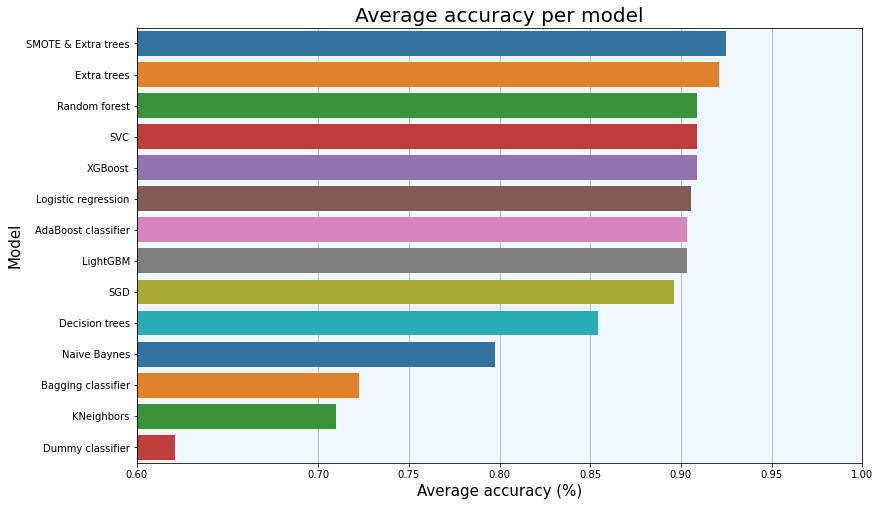

In [10]:
fig_dims = (13, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y=list(accuracies.keys()), x=list(accuracies.values()), palette='tab10',)
plt.title('Average accuracy per model', fontdict ={'size': 20})
plt.ylabel('Model', fontdict ={'size': 15})
plt.xlabel('Average accuracy (%)',fontdict ={'size': 15})
ax.set_facecolor("aliceblue") #setting background color
plt.xticks([0.6,0.7,0.75,0.8,0.85,0.9,0.95,1])
plt.xlim([0.6, 1])
ax.set_axisbelow(True)
plt.grid(axis = 'x')
plt.show()